<a href="https://colab.research.google.com/github/Samarth-991/Deep-Learning/blob/master/31_FaulDetection_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fault Detection Dataset 
This dataset is of casting manufacturing product.
Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.
Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.
There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.
Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate. This can because of the rejection of the whole order. So it creates a big loss in the company.

In [1]:
import numpy as np
import csv
import pandas as pd
import time
import cv2
import os
import glob
import random
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from  tensorflow.keras.preprocessing import image
import gc 
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)
print(cv2.__version__)
rand = np.random.seed(46)

2.4.0
4.1.2


In [2]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product
# !unzip /content/real-life-industrial-dataset-of-casting-product.zip
# ! rm -rf /content/real-life-industrial-dataset-of-casting-product.zip

In [3]:
defect_path = '/content/casting_512x512/casting_512x512/def_front'
Ok_path = '/content/casting_512x512/casting_512x512/ok_front'

train300_path =  '/content/casting_data/casting_data/train'
test300_path = '/content/casting_data/casting_data/test'

train_data = glob.glob(train300_path+'/*/*.jpeg')
print("Train data ",len(train_data))
test_data =  glob.glob(test300_path+'/*/*.jpeg')
print("Test data ",len(test_data))

defect_data = glob.glob(defect_path+'/*.jpeg')
print("defective data",len(defect_data))
Ok_data = glob.glob(Ok_path+'/*.jpeg')
print("OK Defective data",len(Ok_data))

Train data  6633
Test data  715
defective data 781
OK Defective data 519


In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10
INIT_LR = 1e-3
STEPS_PER_EPOCH = len(train_data)//BATCH_SIZE
CLASS_LABELS = ['def_front','ok_front']

In [5]:
for label in CLASS_LABELS:
  print("Train images for {} is {}".format(label,len(os.listdir(os.path.join(train300_path,label)))))
print('\n')

for label in CLASS_LABELS:
  print("Test images for {} is {}".format(label,len(os.listdir(os.path.join(test300_path,label)))))

Train images for def_front is 3758
Train images for ok_front is 2875


Test images for def_front is 453
Test images for ok_front is 262


In [6]:
def generate_imgdataframe(data,save_as='train.csv'):
    labels = []
    filenames = []
    image_shape = []
    for imgfile in data:
        filename = os.path.basename(imgfile)
        label = os.path.basename(os.path.split(imgfile)[0])
        img = plt.imread(imgfile)
        
        image_shape.append(img.shape)
        labels.append(label)
        filenames.append(filename)
    df = pd.DataFrame({'filename':filenames,'Class':labels,'shape':image_shape})
    df.to_csv(save_as)
    return df

In [7]:
train_df = generate_imgdataframe(train_data,'train.csv')
train_df.head()

,filename,Class,shape
0,cast_ok_0_5237.jpeg,ok_front,"(300, 300, 3)"
1,cast_ok_0_935.jpeg,ok_front,"(300, 300, 3)"
2,cast_ok_0_2779.jpeg,ok_front,"(300, 300, 3)"
3,cast_ok_0_5819.jpeg,ok_front,"(300, 300, 3)"
4,cast_ok_0_3133.jpeg,ok_front,"(300, 300, 3)"


37

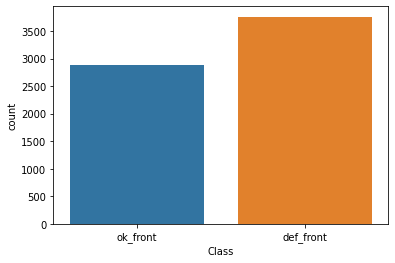

In [8]:
sns.countplot(train_df['Class'])
gc.collect()

['def_front/cast_def_0_3076.jpeg', 'ok_front/cast_ok_0_5105.jpeg']


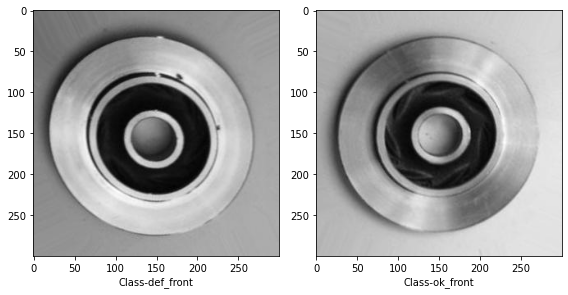

In [9]:
df = train_df.groupby(['Class'])['filename']
imgs_perId = []
for id , name in df:
    img_path = os.path.join(str(id),name[random.choice(name.index)])
    imgs_perId.append(img_path)
print(imgs_perId)

# Display Multiple images in a matix 
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1

for i in range(1, columns*rows +1):
    img = plt.imread(os.path.join(train300_path,imgs_perId[i-1]))
    fig.add_subplot(rows, columns, i,xlabel="Class-"+imgs_perId[i-1].split('/')[0])
    plt.imshow(img)
fig.tight_layout()

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
# This is one of the ways to create training data batch and label batch 
image_generator = image.ImageDataGenerator(rescale=1./255,
                                rotation_range=0.2,
                                zoom_range=0.2,
                                samplewise_std_normalization= True,
                                #brightness_range=[2,5],
                                horizontal_flip=False,
                                vertical_flip=True,
                                validation_split=.25
                                )

train_data_gen = image_generator.flow_from_directory(directory=str(train300_path),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='binary',
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                )

validation_generator = image_generator.flow_from_directory(test300_path,
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode='binary',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    )

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [11]:
CLASS_NAMES = train_data_gen.class_indices
Labels = list(CLASS_NAMES.keys())
print(Labels)
print(CLASS_NAMES)

['def_front', 'ok_front']
{'def_front': 0, 'ok_front': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


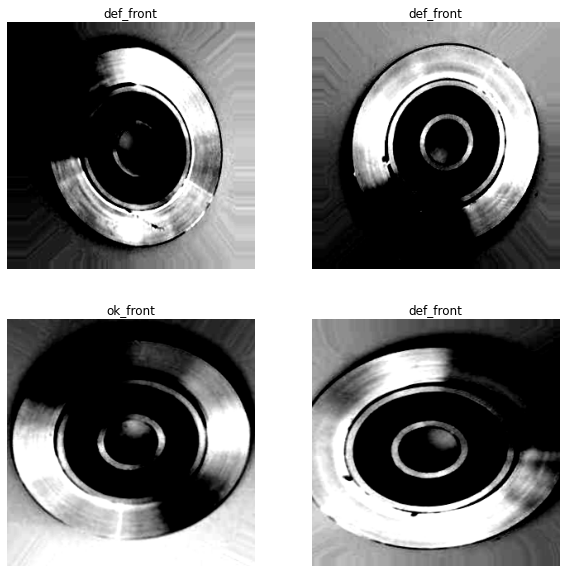

In [12]:
plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    generated_image, labels  = train_data_gen.__getitem__(i)
    plt.imshow(generated_image[i].reshape(IMG_SHAPE))
    plt.title(Labels[int(labels[i])])
    plt.axis("off")

## Configure the Dataset Performance

In [13]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_dataset = train_data_gen.(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augumentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

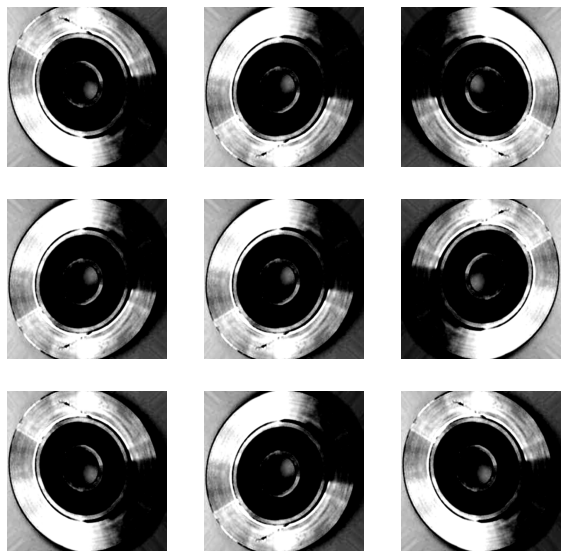

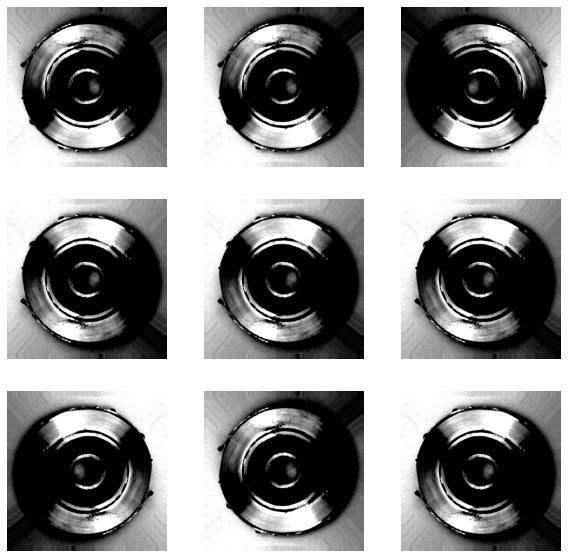

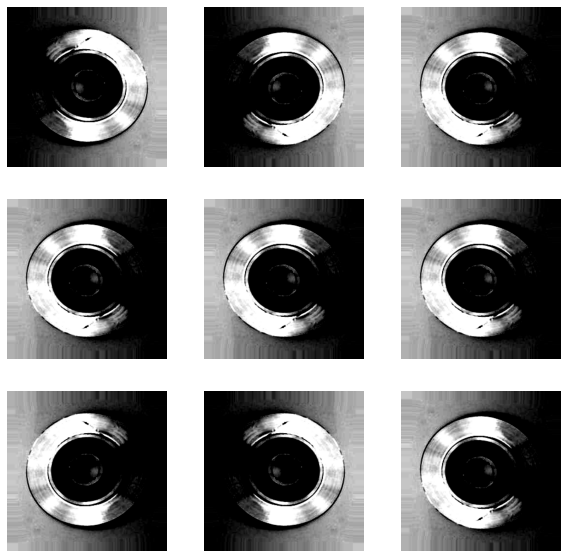

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical')
])
generated_image, labels  = train_data_gen.__getitem__(0)

for timage in generated_image[:3]:
  timage = timage.reshape(IMG_SHAPE)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(timage, 0))
    augmented_image = np.reshape(augmented_image,IMG_SHAPE)
    plt.imshow(augmented_image)
    plt.axis('off')

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Conv2D,MaxPool2D,BatchNormalization
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2,InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

# Define the basic TensorBoard callback.
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

# Define Check point 
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_path = "InceptionV3/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,monitor='val_loss', verbose=1,
                            save_best_only=True,mode='min')
callbacks_list = [cp_callback,tensorboard_callback]

In [16]:
# Pre-trained model 
base_model = InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=None)
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

for layers in base_model.layers[:50]:
    layers.trainable=True

Number of layers in the base model:  311


In [17]:
def build_model_1():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Flatten(name="Flatten")(x)
    x = tf.keras.layers.Dense(256,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(2,activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs,outputs=prediction_layer)
    return model

def build_model_2():
    x = base_model.output
    x = data_augmentation(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)   
    x = Dense(64,activation='relu')(x)
    x = Dropout(0.2)(x)
    prediction_layer = Dense(2,activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

def build_model_3():
    model = Sequential()
    # first conv batch
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same', input_shape=IMG_SHAPE))
    model.add(data_augmentation)
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
    padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax'))
    return model

#model = build_model_1()
model = build_model_2()
# model = build_model_3()
gc.collect()

36129

In [18]:
# remove previous logs 
! rm -rf /content/logs
! rm -rf /content/InceptionV3

In [19]:
# Define Hyperparameters 
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

opt = Adam(lr=INIT_LR)
#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# Fitting the model 
H = model.fit(train_data_gen,epochs=EPOCHS,callbacks=callbacks_list,
              validation_data = validation_generator
              )

Epoch 1/20
208/208 [==============================] - 187s 847ms/step - loss: 0.4511 - accuracy: 0.7903 - val_loss: 2.1791 - val_accuracy: 0.6238

Epoch 00001: val_loss improved from inf to 2.17915, saving model to InceptionV3/cp.ckpt
Epoch 2/20
208/208 [==============================] - 172s 826ms/step - loss: 0.1331 - accuracy: 0.9598 - val_loss: 0.2810 - val_accuracy: 0.9734

Epoch 00002: val_loss improved from 2.17915 to 0.28096, saving model to InceptionV3/cp.ckpt
Epoch 3/20
208/208 [==============================] - 172s 824ms/step - loss: 0.1022 - accuracy: 0.9639 - val_loss: 37.5447 - val_accuracy: 0.6909

Epoch 00003: val_loss did not improve from 0.28096
Epoch 4/20
208/208 [==============================] - 172s 824ms/step - loss: 0.0825 - accuracy: 0.9750 - val_loss: 34.6275 - val_accuracy: 0.6783

Epoch 00004: val_loss did not improve from 0.28096
Epoch 5/20
208/208 [==============================] - 171s 822ms/step - loss: 0.0586 - accuracy: 0.9829 - val_loss: 3.4856 - val

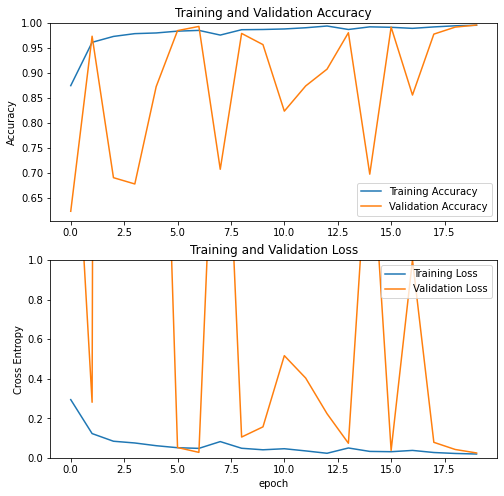

In [21]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy :', accuracy)

36/36 [==============================] - 14s 391ms/step - loss: 0.0259 - accuracy: 0.9986
Test accuracy : 0.9986013770103455


## Model Evaluation

In [23]:
# make predictions on the testing set
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("[INFO] evaluating network...")
predictions=[]

def decode_image(filename,shape):
    img = tf.keras.preprocessing.image.load_img(filename,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.astype(np.float32)/255.0
    return img

predicted_vals = model.predict_generator(validation_generator)
y_pred  = [np.argmax(proab) for proab in predicted_vals]
y_test = validation_generator.labels
print(classification_report(y_test, y_pred))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       453
           1       0.36      0.36      0.36       262

    accuracy                           0.53       715
   macro avg       0.49      0.49      0.49       715
weighted avg       0.53      0.53      0.53       715



In [24]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
Senstivity  = tp/(tp+fn)
Specificity = tn/(tn+fp)

print("Senstivity = ",Senstivity)
print ("Specificity = ",Specificity)
print("Accuracy score",accuracy_score(y_test,y_pred))

Senstivity =  0.35877862595419846
Specificity =  0.6269315673289183
Accuracy score 0.5286713286713287


In [38]:
from google.colab.patches import cv2_imshow 

ORIGINAL = defect_data[random.randint(0,len(defect_data)-1)]
original_img = cv2.imread(ORIGINAL)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
print("Image: ",ORIGINAL)
print("Shape of image :",original_img.shape)
print(original_img.shape)

img = decode_image(ORIGINAL,shape=IMG_SHAPE)
img = np.expand_dims(img,axis=0)
# Preict with the model
idx = np.argmax(model.predict(img))
print("Predicted label ",Labels[idx])

Image:  /content/casting_512x512/casting_512x512/def_front/cast_def_0_383.jpeg
Shape of image : (512, 512, 3)
(512, 512, 3)
Predicted label  def_front


## Explainability Using GradCAM
Refernce : https://towardsdatascience.com/explainability-and-visibility-in-covid-19-x-ray-classifiers-with-deep-learning-c12c3247f905

In [39]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

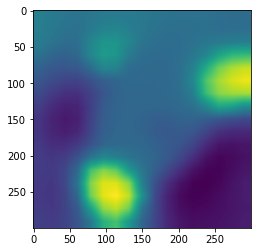

In [40]:
cam = GradCAM(model=model, classIdx=idx, layerName='conv2d_72') # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(img)

#show the calculated heatmap
plt.imshow(heatmap)
plt.show()

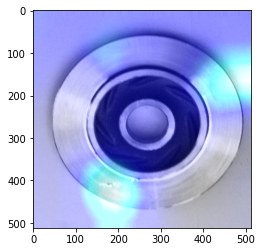

In [41]:
# Old fashioned way to overlay a transparent heatmap onto original image, the same as above
INTENSITY = 0.5
heatmapY = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT) 
imageY = cv2.addWeighted(heatmapY, 0.5, original_img, 1.0, 0)
plt.imshow(imageY)

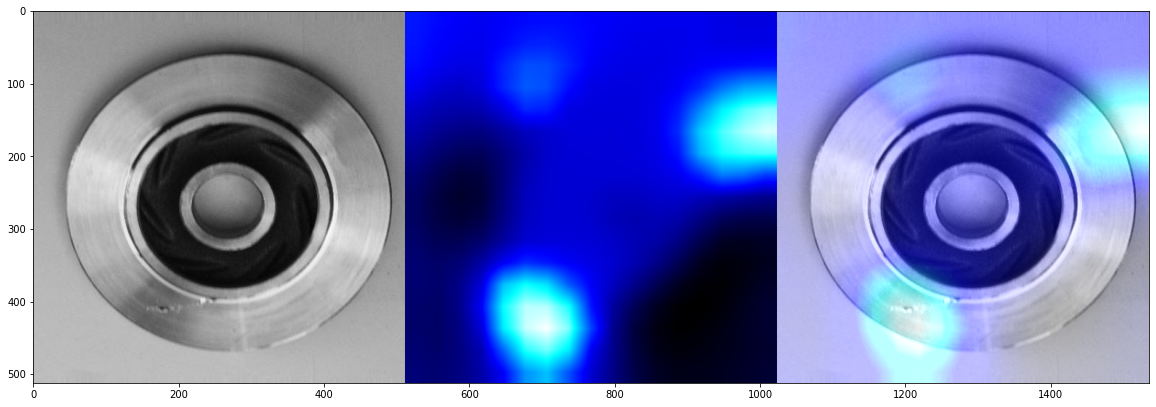

In [42]:
# draw the orignal x-ray, the heatmap, and the overlay together
output = np.hstack([original_img, heatmapY, imageY])
fig, ax = plt.subplots(figsize=(20, 18))
ax.imshow(np.random.rand(1, 99), interpolation='nearest')
plt.imshow(output)
plt.show()